In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('upPackets.csv', sep= ";")

In [3]:
df.head()

,id,gwui,time,tmms,tmst,freq,chan,rfch,stat,modu,datr,codr,rssi,lsnr,size,data
0,33,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,SF7BW125,4/5,-100,2.8,9,CieFBjcaAv4B
1,34,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,SF7BW125,4/5,-99,4.0,9,CieFBjcaAv4B
2,35,AC1F09FFFE057698,Nan,Nan,1729188407,868.3,1,1,1,LORA,SF7BW125,4/5,-104,2.3,8,C8bTDAVZBQA=
3,36,AC1F09FFFE057698,Nan,Nan,1729188407,868.3,1,1,1,LORA,SF7BW125,4/5,-104,0.5,9,C8bTDAVZAv4B
4,37,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,SF7BW125,4/5,-111,1.5,8,CyCSDMkzAQA=


In [4]:
df.shape

(5895982, 16)

### Decoding Data Column

In [5]:
import base64
from pprint import pprint

def decode_lorawan_packet(base64_packet):
    try:
        # Decode the base64 packet into bytes
        packet_bytes = base64.b64decode(base64_packet)

        # Initialize an empty dictionary to store packet components
        packet_dict = {}

        # Extracting the MHDR (Message Header)
        packet_dict['MHDR'] = packet_bytes[0]
        packet_dict['MType'] = (packet_bytes[0] >> 5) & 0x07
        packet_dict['RFU'] = (packet_bytes[0] >> 2) & 0x07
        packet_dict['Major'] = packet_bytes[0] & 0x03

        # Extract DevAddr (4 bytes, little-endian)
        devaddr_bytes = packet_bytes[1:5]
        packet_dict['DevAddr'] = devaddr_bytes[::-1].hex()

        # FCtrl (Frame Control)
        packet_dict['FCtrl'] = packet_bytes[5]

        # FCnt (Frame Counter, 2 bytes, little-endian)
        fcnt_bytes = packet_bytes[6:8]
        packet_dict['FCnt'] = int.from_bytes(fcnt_bytes, byteorder='little')

        # Optional FOpts (Frame Options), its length depends on the lower 4 bits of FCtrl
        fopts_length = packet_dict['FCtrl'] & 0x0F
        fopts_end = 8 + fopts_length
        packet_dict['FOpts'] = packet_bytes[8:fopts_end].hex() if fopts_length > 0 else None

        # FPort (1 byte after FOpts, if present)
        if len(packet_bytes) > fopts_end:
            packet_dict['FPort'] = packet_bytes[fopts_end]
            fopts_end += 1
        else:
            packet_dict['FPort'] = None

        # FRMPayload (remaining bytes after FPort)
        if len(packet_bytes) > fopts_end:
            packet_dict['FRMPayload'] = packet_bytes[fopts_end:].hex()
        else:
            packet_dict['FRMPayload'] = None

        return packet_dict
    except:
        return None

In [6]:
decoded_df = df["data"].apply(decode_lorawan_packet).apply(pd.Series)

df = pd.concat([df.drop(columns=["data"]), decoded_df], axis=1)

In [8]:
df_null_frmpayload = df[df['FRMPayload'].isnull()]
df_valid_packets = df[df['FRMPayload'].notnull()]

In [17]:
df

,id,gwui,time,tmms,tmst,freq,chan,rfch,stat,modu,...,MHDR,MType,RFU,Major,DevAddr,FCtrl,FCnt,FOpts,FPort,FRMPayload
0,33,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,...,10.0,0.0,2.0,2.0,37068527,26.0,65026.0,01,NaN,None
1,34,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,...,10.0,0.0,2.0,2.0,37068527,26.0,65026.0,01,NaN,None
2,35,AC1F09FFFE057698,Nan,Nan,1729188407,868.3,1,1,1,LORA,...,11.0,0.0,2.0,3.0,050cd3c6,89.0,5.0,,NaN,None
3,36,AC1F09FFFE057698,Nan,Nan,1729188407,868.3,1,1,1,LORA,...,11.0,0.0,2.0,3.0,050cd3c6,89.0,65026.0,01,NaN,None
4,37,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,...,11.0,0.0,2.0,3.0,c90c9220,51.0,1.0,,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5895977,5896010,AC1F09FFFE057698,Nan,Nan,1747321399,868.3,1,1,1,LORA,...,11.0,0.0,2.0,3.0,050c68fc,89.0,65026.0,01,NaN,None
5895978,5896011,AC1F09FFFE057698,Nan,Nan,1747321400,868.1,0,1,1,LORA,...,12.0,0.0,3.0,0.0,200ba22c,146.0,65026.0,01,NaN,None
5895979,5896012,AC1F09FFFE057698,Nan,Nan,1747321404,868.5,2,1,1,LORA,...,13.0,0.0,3.0,1.0,2dc0b19b,170.0,1.0,,NaN,None
5895980,5896013,AC1F09FFFE057698,Nan,Nan,1747321404,868.5,2,1,1,LORA,...,192.0,6.0,0.0,0.0,9b0daa2d,177.0,65026.0,01,NaN,None


Number of packets per gateway:
gwui
AC1F09FFFE057698    5895979
1CD868E17E4DB54C          3
Name: count, dtype: int64


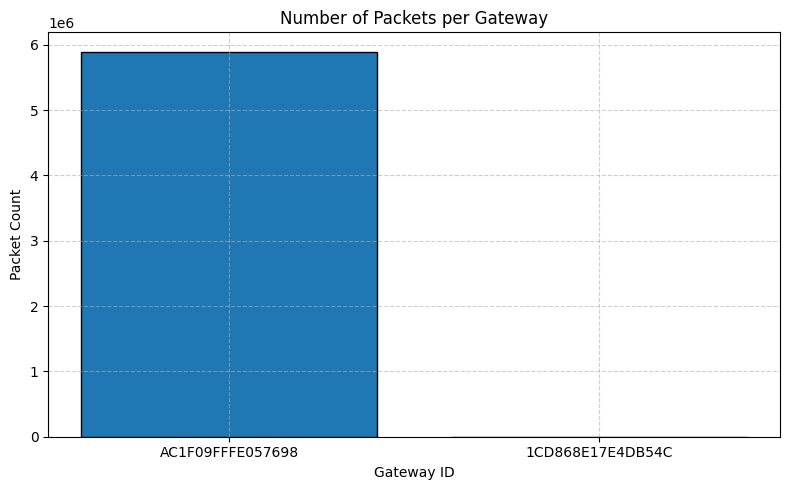

In [25]:
import matplotlib.pyplot as plt

# Count packets received by each gateway
gateway_counts = df['gwui'].value_counts()

print("Number of packets per gateway:")
print(gateway_counts)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(gateway_counts.index.astype(str), gateway_counts.values, edgecolor='black')
plt.title('Number of Packets per Gateway')
plt.xlabel('Gateway ID')
plt.ylabel('Packet Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [11]:
df['gwui'].value_counts()

gwui
AC1F09FFFE057698    5895979
1CD868E17E4DB54C          3
Name: count, dtype: int64

### Valid Packets Analysis

#### Activity Counts per Device

Top 10 most active devices:
DevAddr
f3181dbe    99371
00000000    60180
c90c9220    56817
000000d8    36993
c80c9220    27094
01010101    25162
2b0404ee    20570
015eb0df    18420
60000000    14546
e011be04     9406
Name: count, dtype: int64


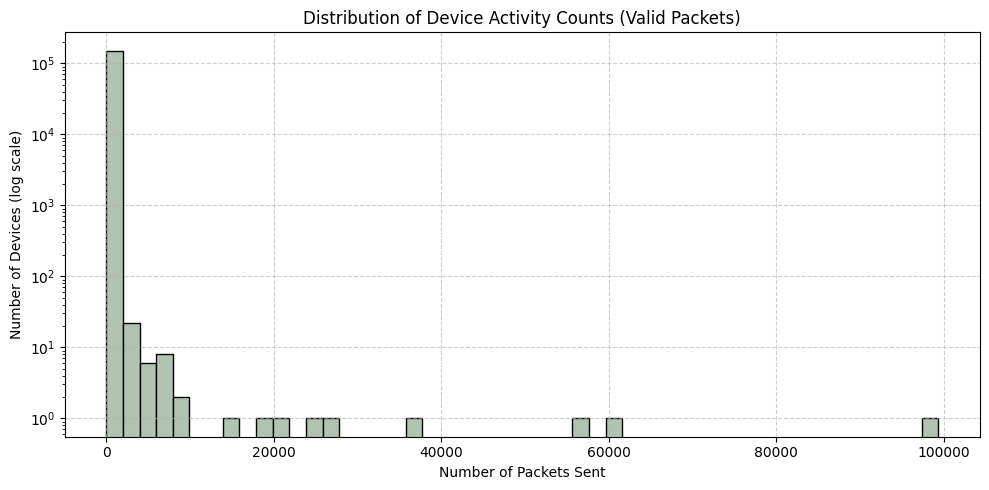

In [37]:
import matplotlib.pyplot as plt

# Count total packets per device (valid only)
device_activity_counts = df_valid_packets['DevAddr'].value_counts()

print("Top 10 most active devices:")
print(device_activity_counts.head(10))

# Plot histogram of device activity counts
plt.figure(figsize=(10, 5))
plt.hist(device_activity_counts, bins=50, color='#b0c4b1', edgecolor='black', log=True)
plt.title('Distribution of Device Activity Counts (Valid Packets)')
plt.xlabel('Number of Packets Sent')
plt.ylabel('Number of Devices (log scale)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


- Most devices sent very few packets (1–100) — typical for low-traffic or rarely used devices.
- A small group of devices sent tens of thousands of packets — these are the super active devices or core sensors.
- The log scale shows a heavy tail distribution — a few devices dominate traffic.

#### Hourly Activity of Top 5 Valid Devices

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_21776/426757601.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid_packets['hour'] = pd.to_datetime(df_valid_packets['tmst'], unit='s').dt.hour


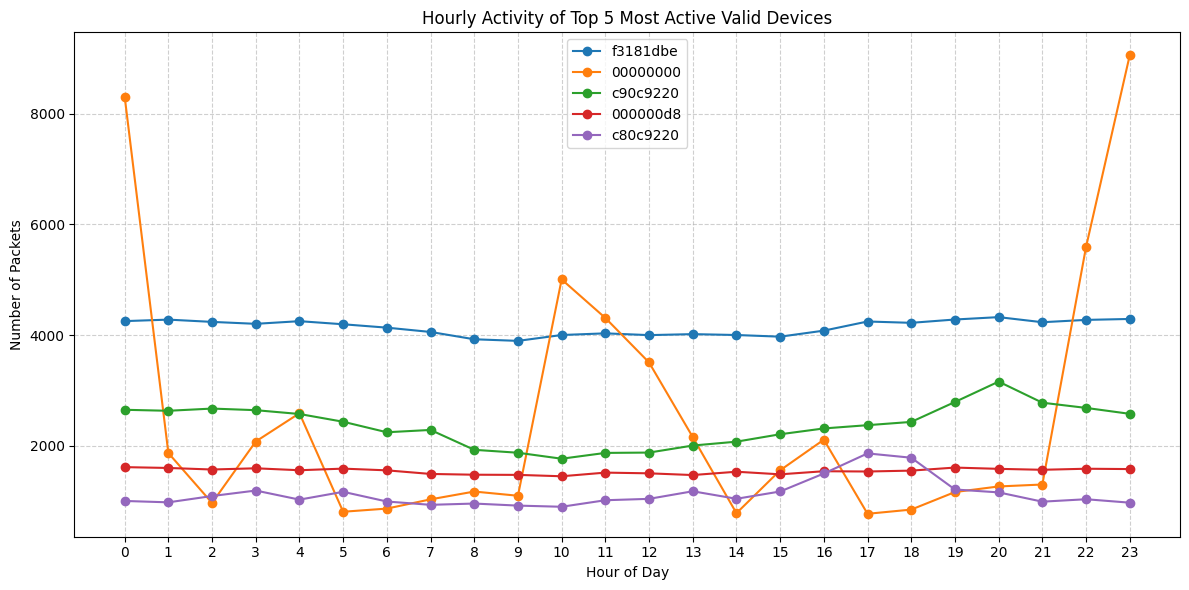

In [36]:
import matplotlib.pyplot as plt

# Identify top 5 most active valid devices
top_5_valid_devices = device_activity_counts.head(5).index.tolist()

# Extract hour of day from timestamps (if not already done)
df_valid_packets['hour'] = pd.to_datetime(df_valid_packets['tmst'], unit='s').dt.hour

# Plot hourly activity for each of the top 5 valid devices
plt.figure(figsize=(12, 6))

for dev in top_5_valid_devices:
    hourly_counts = df_valid_packets[df_valid_packets['DevAddr'] == dev]['hour'].value_counts().sort_index()
    plt.plot(hourly_counts.index, hourly_counts.values, marker='o', label=str(dev))

plt.title('Hourly Activity of Top 5 Most Active Valid Devices')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Packets')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


✅ Device f3181dbe (blue line):

Has very steady activity throughout the day (~4,000 packets/hour).

No significant peaks or dips — likely a critical, always-on device.

✅ Device 00000000 (orange line):

Large spike at midnight (8,000+ packets!).

Another spike around 10–11 AM and late evening (10–11 PM).

Indicates burst behavior — maybe a mobile device or periodic reporting sensor.

✅ Device c90c9220 (green line):

More gradual activity during the day, slight peak in the evening — maybe environment or usage-based.

✅ Devices 000000d8 and c80c9220 (red/purple lines):

Lower volume, but steady activity without big hourly fluctuations.

Daily Activity of Top 5 Valid Devices

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_21776/2545001424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid_packets['date'] = pd.to_datetime(df_valid_packets['tmst'], unit='s').dt.date


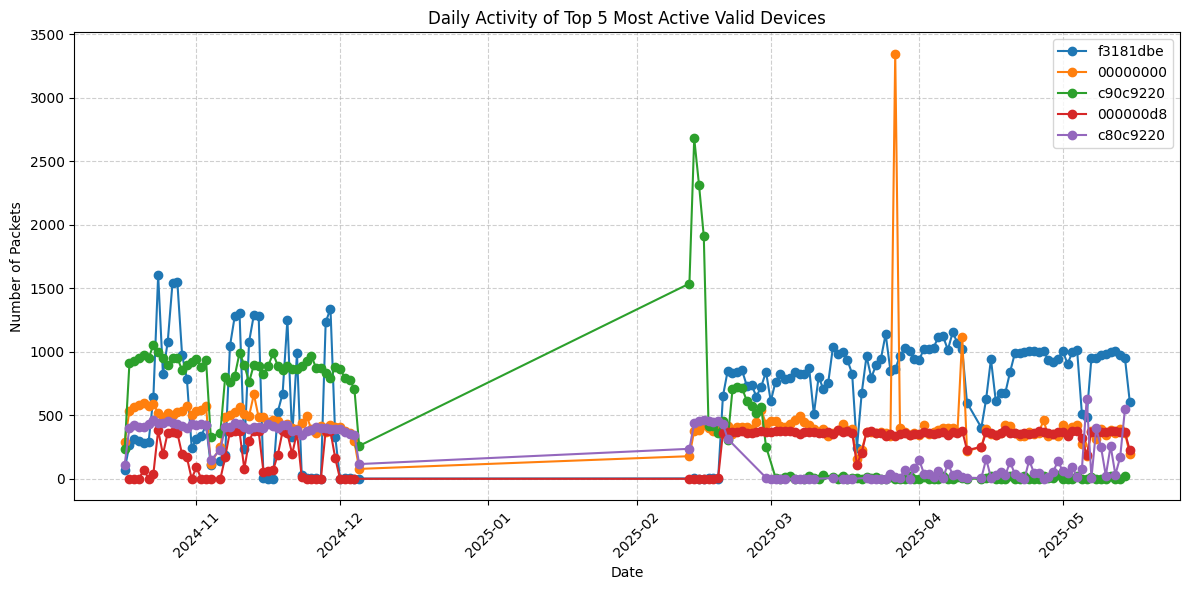

In [39]:
import matplotlib.pyplot as plt

# Extract date from timestamp for valid packets
df_valid_packets['date'] = pd.to_datetime(df_valid_packets['tmst'], unit='s').dt.date

# Identify top 5 valid devices
top_5_valid_devices = device_activity_counts.head(5).index.tolist()

# Plot daily activity for each top valid device
plt.figure(figsize=(12, 6))

for dev in top_5_valid_devices:
    daily_counts = df_valid_packets[df_valid_packets['DevAddr'] == dev]['date'].value_counts().sort_index()
    plt.plot(daily_counts.index, daily_counts.values, marker='o', label=str(dev))

plt.title('Daily Activity of Top 5 Most Active Valid Devices')
plt.xlabel('Date')
plt.ylabel('Number of Packets')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


✅ Device f3181dbe (blue):

Shows consistent daily activity throughout the entire period.

Small day-to-day fluctuations, but generally steady — likely a fixed, always-on sensor.

✅ Device 00000000 (orange):

Mostly steady, but has a huge spike in April 2025 (over 3,000 packets) — might be a maintenance event or reconfiguration burst.

✅ Device c90c9220 (green):

Significant gaps in activity — periods of inactivity, then sudden bursts (like in February 2025).

Could indicate periodic mobility (like a mobile asset) or network coverage fluctuations.

✅ Devices 000000d8 and c80c9220 (red/purple):

Lower overall volumes, but very steady — classic of low-traffic, static sensors.

#### RSSI/SNR Stats per Device

    DevAddr   rssi_mean   rssi_std   snr_mean   snr_std
0  00000000 -121.306913   7.161660 -11.744010  4.973490
1  00000001 -123.117897   6.727198 -12.241052  5.375674
2  00000002 -129.016043   3.841589 -14.520856  2.774683
3  00000003 -124.651007   5.742123 -11.126846  4.880236
4  00000004 -120.204878  11.369764  -8.252195  8.442386


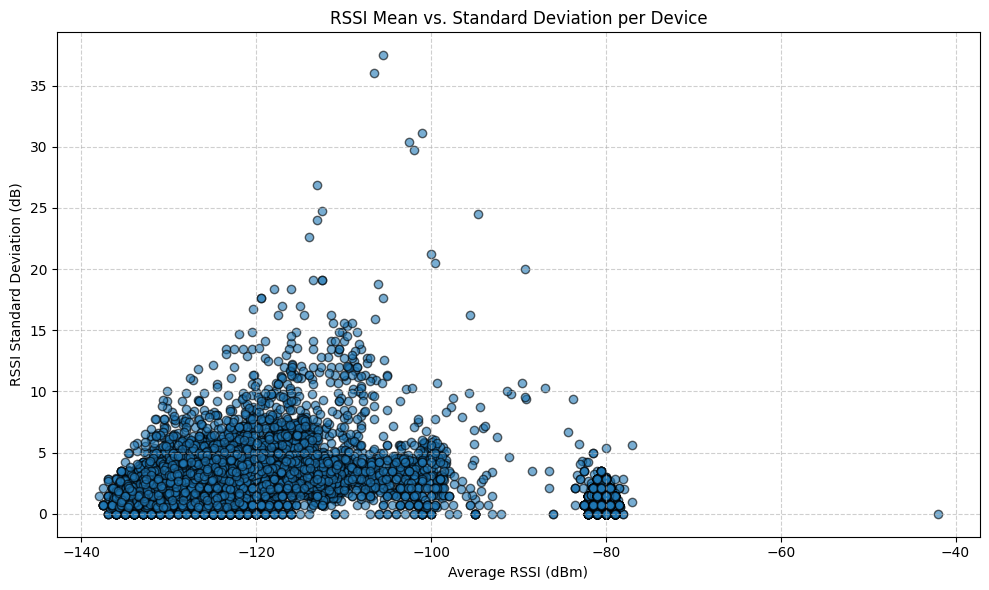

In [12]:
# Calculate RSSI and SNR average and variance per device
rssi_snr_stats = df_valid_packets.groupby('DevAddr').agg({
    'rssi': ['mean', 'std'],
    'lsnr': ['mean', 'std']
}).reset_index()

# Rename columns for clarity
rssi_snr_stats.columns = ['DevAddr', 'rssi_mean', 'rssi_std', 'snr_mean', 'snr_std']

# Show top rows
print(rssi_snr_stats.head())

# Plot RSSI mean vs. std scatter to see stability
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(rssi_snr_stats['rssi_mean'], rssi_snr_stats['rssi_std'], alpha=0.6, edgecolors='black')
plt.title('RSSI Mean vs. Standard Deviation per Device')
plt.xlabel('Average RSSI (dBm)')
plt.ylabel('RSSI Standard Deviation (dB)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


-  Most devices cluster between -140 dBm and -100 dBm average RSSI — typical for LoRaWAN’s long-range, low-power characteristics.
-  RSSI variance (standard deviation) mostly below 10 dB, suggesting relatively stable links for the majority of devices.
-  A smaller group of outlier devices has RSSI variance above 20 dB — these are likely mobile or in dynamic environments.

List Most Unstable Devices

In [13]:
# Sort devices by RSSI standard deviation (descending)
most_unstable_devices = rssi_snr_stats.sort_values(by='rssi_std', ascending=False).head(10)

print("Top 10 most unstable devices based on RSSI variance:")
print(most_unstable_devices[['DevAddr', 'rssi_mean', 'rssi_std', 'snr_mean', 'snr_std']])

Top 10 most unstable devices based on RSSI variance:
         DevAddr   rssi_mean   rssi_std   snr_mean    snr_std
147995  fc256e00 -105.500000  37.476659  -4.500000  17.677670
149291  fc4bc000 -106.500000  36.062446  -4.250000  18.455487
149129  fc409700 -101.000000  31.112698  -3.500000  16.970563
143890  fc089100 -102.500000  30.405592  -3.100000  15.414928
149070  fc3e0b00 -102.000000  29.698485  -1.100000  15.414928
56539   1e88ad54 -113.000000  26.870058  -5.750000  14.212846
92394   80002900 -112.500000  24.748737  -5.350000  15.768481
143217  fc058300  -94.666667  24.542480   2.166667  12.112941
10406   0072cc1a -113.000000  24.041631 -19.300000   0.707107
90872   7c3d0200 -114.000000  22.627417  -5.000000  14.566400


- These devices have very high RSSI variance (22 dB to 37 dB!) — indicating highly dynamic links.

- Their average RSSI values range from -94 dBm to -114 dBm — typical for weak links, but not the absolute worst.

- Their SNR standard deviation is also very high (often > 15 dB), suggesting fast-changing environments or significant mobility.

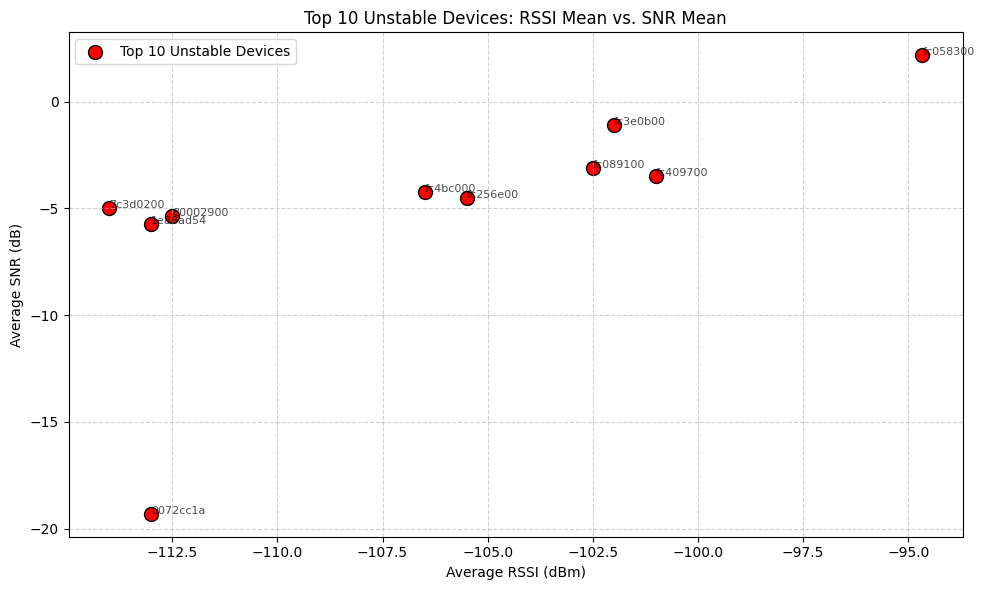

In [14]:

# Top 10 unstable devices (already calculated)
unstable_devices = most_unstable_devices.copy()

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(unstable_devices['rssi_mean'], unstable_devices['snr_mean'],
            color='red', edgecolor='black', s=100, label='Top 10 Unstable Devices')

# Label points with DevAddr
for i, row in unstable_devices.iterrows():
    plt.text(row['rssi_mean'], row['snr_mean'], row['DevAddr'], fontsize=8, alpha=0.7)

plt.title('Top 10 Unstable Devices: RSSI Mean vs. SNR Mean')
plt.xlabel('Average RSSI (dBm)')
plt.ylabel('Average SNR (dB)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


- Most of these unstable devices have weak average RSSI (~ -110 to -100 dBm) — typical of far or shielded devices.
- Their average SNRs also tend to be low (~ -5 dB to -15 dB) — typical for noisy or low-signal environments.
- One device (fc058300) is a clear outlier with high average SNR (~2 dB) even though its average RSSI is weak (around -94 dBm).
This could suggest:

- -  A device in a less noisy environment (high SNR) but far away (low RSSI).

- - Or a device with sporadic high-quality links (e.g., mobile, sometimes close to gateway).

#### Spreading Factor (SF) Usage Patterns

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_21776/2380786556.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid_packets['sf_num'] = df_valid_packets['datr'].str.extract(r'SF(\d+)')[0].astype(float)


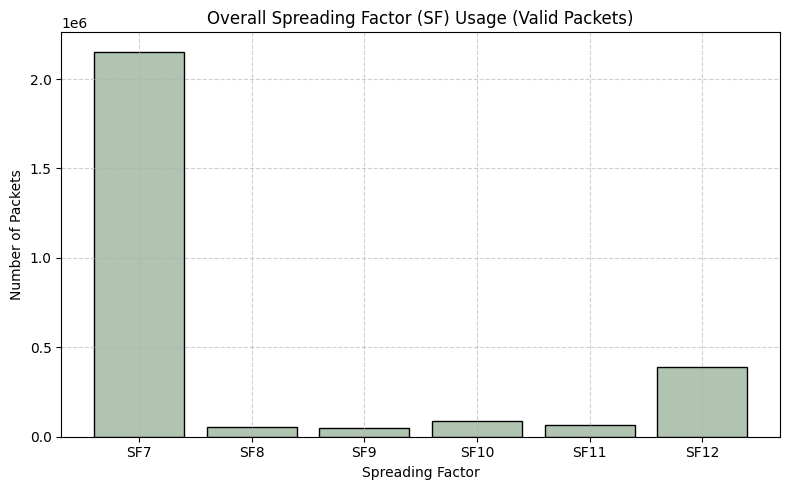

Spreading Factor usage counts:
sf_num
7.0     2153308
8.0       51643
9.0       50621
10.0      90585
11.0      65076
12.0     391483
Name: count, dtype: int64


In [22]:
import matplotlib.pyplot as plt

# Extract numeric SF (if not already done)
df_valid_packets['sf_num'] = df_valid_packets['datr'].str.extract(r'SF(\d+)')[0].astype(float)

# Count SF usage
sf_counts_valid = df_valid_packets['sf_num'].value_counts().sort_index()

# Relabel for better plots
sf_labels = [f'SF{int(sf)}' for sf in sf_counts_valid.index]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(sf_labels, sf_counts_valid.values, color='#b0c4b1', edgecolor='black')
plt.title('Overall Spreading Factor (SF) Usage (Valid Packets)')
plt.xlabel('Spreading Factor')
plt.ylabel('Number of Packets')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Spreading Factor usage counts:")
print(sf_counts_valid)


- SF7 dominates (over 2 million packets!) — most devices are close enough to the gateway to use low SF (shorter range, higher data rate).
- SF12 is also significant (about 400k packets) — suggesting some long-range or weaker link devices.
- Other SFs (8–11) are much less used — typical in LoRaWAN deployments, as SF7 is preferred for high data rate and SF12 for long-range fallback.



Per-Device SF Variance

    DevAddr  unique_sf_count
0  00000000                6
1  00000001                6
2  00000002                1
3  00000003                1
4  00000004                1


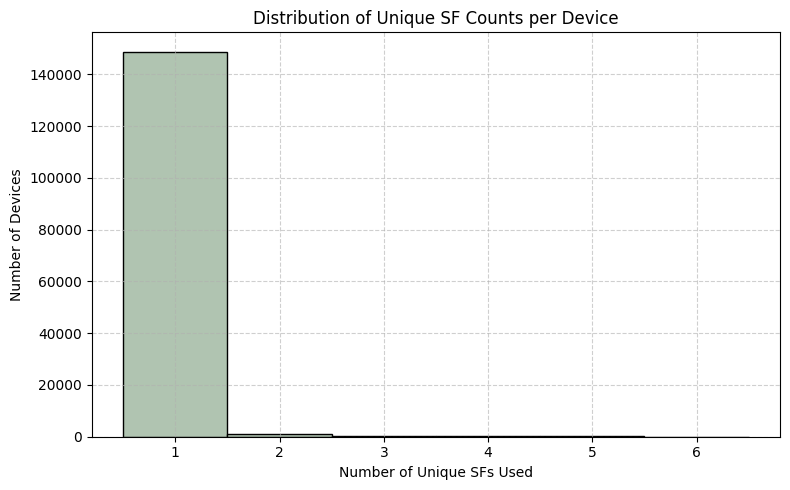

In [24]:
# Count unique SFs used by each device
sf_variance_per_device = df_valid_packets.groupby('DevAddr')['sf_num'].nunique().reset_index()
sf_variance_per_device.columns = ['DevAddr', 'unique_sf_count']

# Show top rows
print(sf_variance_per_device.head())

# Plot distribution of unique SF counts
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(sf_variance_per_device['unique_sf_count'], bins=range(1, sf_variance_per_device['unique_sf_count'].max()+2), color='#b0c4b1', edgecolor='black', align='left')
plt.title('Distribution of Unique SF Counts per Device')
plt.xlabel('Number of Unique SFs Used')
plt.ylabel('Number of Devices')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


- The vast majority of devices (~150,000) only use 1 SF — typical for static or very stable devices in your LoRaWAN network.
- Only a tiny number of devices switch between 2 or more SFs — these are the dynamic or mobile devices or those in variable coverage.

List Devices with Most SF Switching

In [26]:
# Filter for devices using more than 1 SF
dynamic_sf_devices = sf_variance_per_device[sf_variance_per_device['unique_sf_count'] > 1]

# Sort by number of unique SFs used (descending)
dynamic_sf_devices_sorted = dynamic_sf_devices.sort_values(by='unique_sf_count', ascending=False)

print(f"Number of devices that switch SFs: {len(dynamic_sf_devices_sorted)}")
print("Top devices with most SF variations:")
print(dynamic_sf_devices_sorted.head(10))


Number of devices that switch SFs: 1853
Top devices with most SF variations:
         DevAddr  unique_sf_count
0       00000000                6
43079   01db7c8c                6
8163    00594f00                6
17817   00c5811d                6
8380    005ba1fa                6
8394    005bdc8e                6
56979   1fa414de                6
131479  e0108904                6
51713   11223344                6
131503  e010a8ec                6


- 1853 devices in total switch SFs — a small but significant group (~1% of all devices).
- These devices have up to 6 unique SFs — meaning they dynamically adapt from SF7 to SF12 depending on link conditions.

- Top dynamic devices (like 00000000, 01db7c8c, 00594f00, etc.) are very versatile in link adaptation — likely:

Mobile sensors (asset tracking, vehicle monitoring).

Devices in variable environments (factories, urban clutter).

### Invalid Packets Analysis

#### Activity Counts per Device for Invalid Packets

Top 10 most active devices (invalid packets):
DevAddr
7304526b    169259
2b0404ee    156055
37061af8    134150
c90c9220    132982
050cc535    117366
050c4bfc    117340
050c68fc    117304
050ce3c6    117244
050cd0c6    117164
050cd3c6    116856
Name: count, dtype: int64


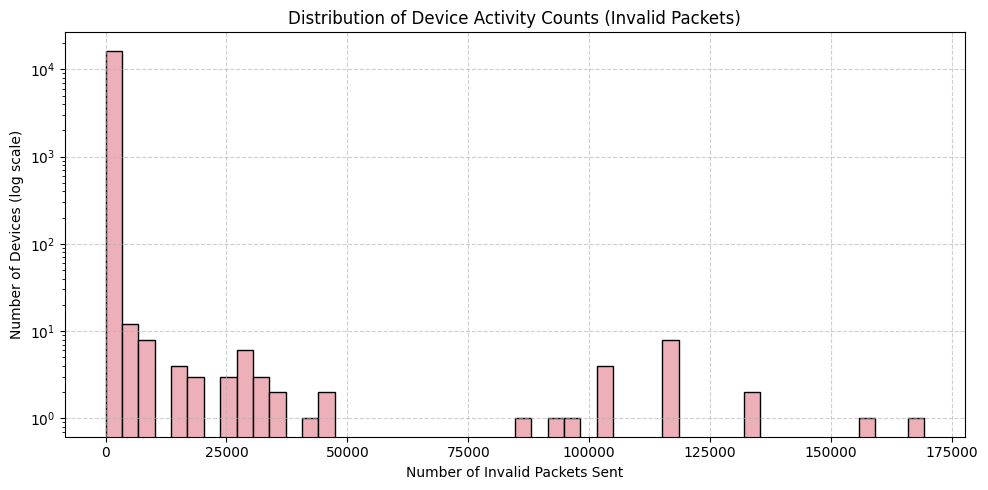

In [35]:
import matplotlib.pyplot as plt

# Count total invalid packets per device
device_activity_counts_invalid = df_null_frmpayload['DevAddr'].value_counts()

print("Top 10 most active devices (invalid packets):")
print(device_activity_counts_invalid.head(10))

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(device_activity_counts_invalid, bins=50, color='#edafb8', edgecolor='black', log=True)
plt.title('Distribution of Device Activity Counts (Invalid Packets)')
plt.xlabel('Number of Invalid Packets Sent')
plt.ylabel('Number of Devices (log scale)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The majority of devices send very few invalid packets — again, typical for low-traffic or well-configured devices.
- A notable group of devices (small but visible tail) sends tens of thousands of invalid packets — possible misconfigured or error-prone devices.

- The heavy-tailed distribution in the log-scale confirms:

Most devices are fine

A small group of devices are error sources — potential maintenance targets!

Hourly Activity of Top 5 Invalid Devices

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_21776/3078874334.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_frmpayload['hour'] = pd.to_datetime(df_null_frmpayload['tmst'], unit='s').dt.hour


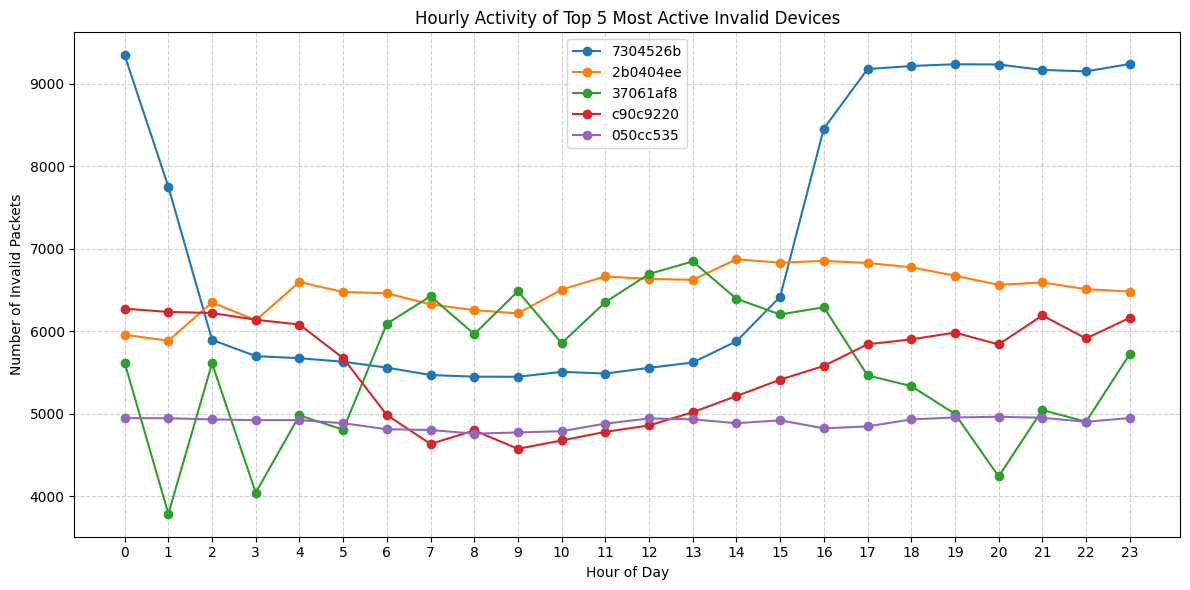

In [38]:
import matplotlib.pyplot as plt

# Identify top 5 most active invalid devices
top_5_invalid_devices = device_activity_counts_invalid.head(5).index.tolist()

# Extract hour of day for invalid packets
df_null_frmpayload['hour'] = pd.to_datetime(df_null_frmpayload['tmst'], unit='s').dt.hour

# Plot hourly activity for each top invalid device
plt.figure(figsize=(12, 6))

for dev in top_5_invalid_devices:
    hourly_counts_invalid = df_null_frmpayload[df_null_frmpayload['DevAddr'] == dev]['hour'].value_counts().sort_index()
    plt.plot(hourly_counts_invalid.index, hourly_counts_invalid.values, marker='o', label=str(dev))

plt.title('Hourly Activity of Top 5 Most Active Invalid Devices')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Invalid Packets')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


✅ Most of these invalid-heavy devices have a steady baseline activity (~5,000–6,000 invalid packets/hour) across the whole day.
✅ Device 7304526b (blue line) has:

A sharp drop after midnight but increases again after 3 PM.

Possible periodic bursts of invalid traffic — maybe linked to an error condition or misconfigured transmission window.

✅ Other devices like 2b0404ee and c90c9220 (orange/red lines) show steady invalid traffic without clear hourly variations — likely consistently faulty or misconfigured.

Daily Activity of Top 5 Invalid Devices

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_21776/3993858001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_frmpayload['date'] = pd.to_datetime(df_null_frmpayload['tmst'], unit='s').dt.date


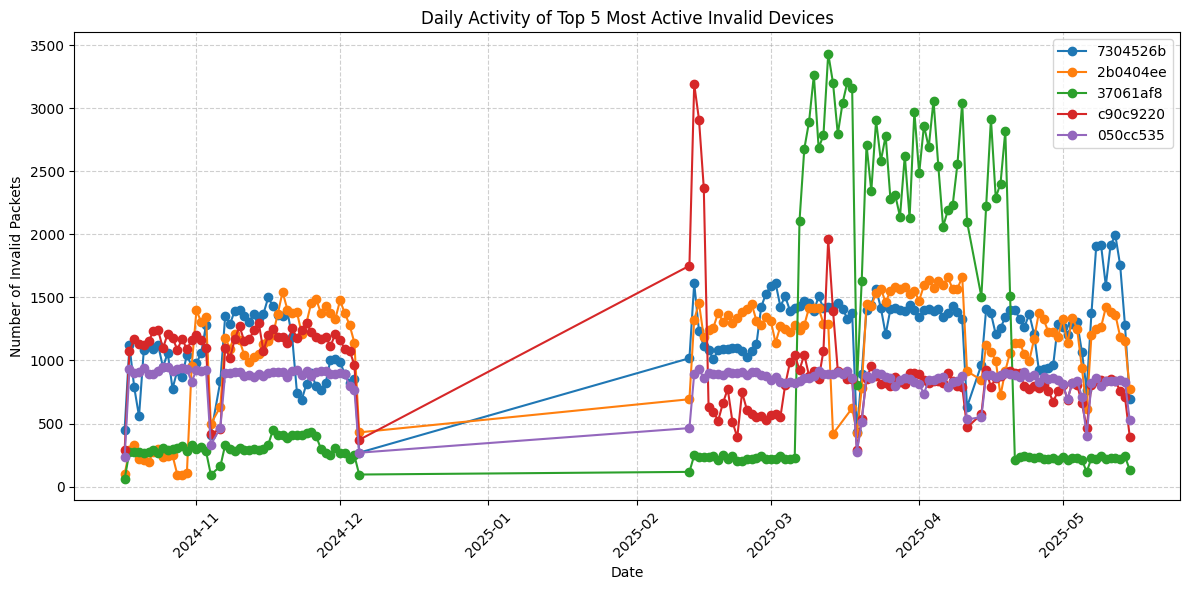

In [40]:
import matplotlib.pyplot as plt

# Extract date from timestamp for invalid packets
df_null_frmpayload['date'] = pd.to_datetime(df_null_frmpayload['tmst'], unit='s').dt.date

# Identify top 5 invalid devices
top_5_invalid_devices = device_activity_counts_invalid.head(5).index.tolist()

# Plot daily activity for each top invalid device
plt.figure(figsize=(12, 6))

for dev in top_5_invalid_devices:
    daily_counts_invalid = df_null_frmpayload[df_null_frmpayload['DevAddr'] == dev]['date'].value_counts().sort_index()
    plt.plot(daily_counts_invalid.index, daily_counts_invalid.values, marker='o', label=str(dev))

plt.title('Daily Activity of Top 5 Most Active Invalid Devices')
plt.xlabel('Date')
plt.ylabel('Number of Invalid Packets')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


✅ Overall Activity

Most devices have persistent invalid activity day after day — some baseline level of errors.

Clear maintenance windows (visible gaps or sudden changes in pattern).

✅ Devices with Bursts / Spikes

c90c9220 (red): Sharp spikes of invalid packets — suggests possible reconfiguration or periodic faults.

37061af8 (green): Fluctuations with major increases — likely mobility or repeated link adaptation failures.

✅ Steady Invalid Activity

Devices like 2b0404ee (orange) and 050cc535 (purple): More stable daily invalid traffic — might indicate systematic misconfiguration rather than dynamic failures.



#### RSSI/SNR Stats per Device

    DevAddr   rssi_mean  rssi_std  snr_mean   snr_std
0  00000355 -105.627168  3.333774  3.219509  5.154612
1  00000356 -105.458101  4.617291  2.915531  5.201620
2  00000358 -117.077790  3.782444 -5.275536  2.769220
3  0000035f -110.331149  3.476113  0.629482  3.630576
4  00000360  -95.540616  4.418971  7.459010  4.921367


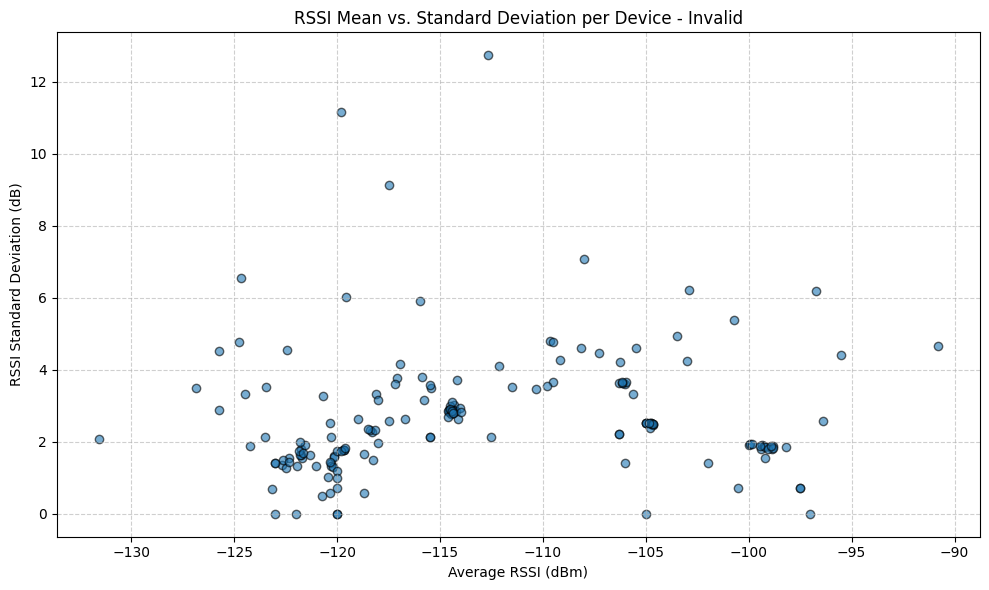

In [28]:
# Calculate RSSI and SNR average and variance per device
rssi_snr_stats = df_null_frmpayload.groupby('DevAddr').agg({
    'rssi': ['mean', 'std'],
    'lsnr': ['mean', 'std']
}).reset_index()

# Rename columns for clarity
rssi_snr_stats.columns = ['DevAddr', 'rssi_mean', 'rssi_std', 'snr_mean', 'snr_std']

# Show top rows
print(rssi_snr_stats.head())

# Plot RSSI mean vs. std scatter to see stability
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(rssi_snr_stats['rssi_mean'], rssi_snr_stats['rssi_std'], alpha=0.6, edgecolors='black')
plt.title('RSSI Mean vs. Standard Deviation per Device - Invalid')
plt.xlabel('Average RSSI (dBm)')
plt.ylabel('RSSI Standard Deviation (dB)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


🔹 Most devices have an average RSSI between -130 dBm and -100 dBm — typical of weak signals.
🔹 RSSI variance (std) mostly stays below 5 dB — suggests that for most devices, even invalid traffic happens in relatively stable link conditions.

🔹 There are a few outliers:

Devices with std deviation above 10 dB — indicates very dynamic environments or movement.

For example, some devices around -120 dBm show up to 12 dB variance — might be mobile sensors or experiencing interference.

List Most Unstable Devices

In [ ]:
# Sort devices by RSSI standard deviation (descending)
most_unstable_devices = rssi_snr_stats.sort_values(by='rssi_std', ascending=False).head(10)

print("Invalid - Top 10 most unstable devices based on RSSI variance:")
print(most_unstable_devices[['DevAddr', 'rssi_mean', 'rssi_std', 'snr_mean', 'snr_std']])

Top 10 most unstable devices based on RSSI variance:
        DevAddr   rssi_mean   rssi_std   snr_mean   snr_std
5058   520a1dd8 -112.666667  12.741010  -3.933333  8.031397
16     0000154d -119.800000  11.166915  -6.200000  9.471008
12576  c1cb6002 -117.500000   9.146948 -11.425000  2.174665
11977  b9a977d8 -108.000000   7.071068   3.500000  7.495332
15517  f000004e -124.666667   6.551911 -14.837500  2.551183
7575   7d04526b -102.882353   6.223768   1.747059  4.344698
5250   55499926  -96.750000   6.184658   6.725000  2.861672
13466  d00006b2 -119.541667   6.023282 -11.315278  2.787935
16210  fc0002ff -115.948276   5.922463  -3.905172  1.902303
7003   7304526b -100.716500   5.374406   2.599319  3.886158


🔹 These devices have very high RSSI variance (up to 12.7 dB!), meaning their signal strength is highly dynamic.
🔹 Devices like 520a1dd8 (rssi_std: 12.7) and 0000154d (11.1) are top unstable — they might be mobile sensors or in dynamic environments (interference, moving machinery, vehicles).

🔹 RSSI Mean Context:

Some have very low average RSSI (like -124 dBm for f000004e), suggesting they’re far from the gateway or heavily obstructed.

Others have better RSSI (like 55499926 at -96 dBm) but still show big fluctuations.

🔹 SNR Variance Context:

Some devices also have high SNR variance (like 0000154d with snr_std 9.47) — signals are not only weak but also noisy.

Others (like c1cb6002) have high RSSI variance but low SNR variance — suggests link instability is purely distance-related rather than noise.

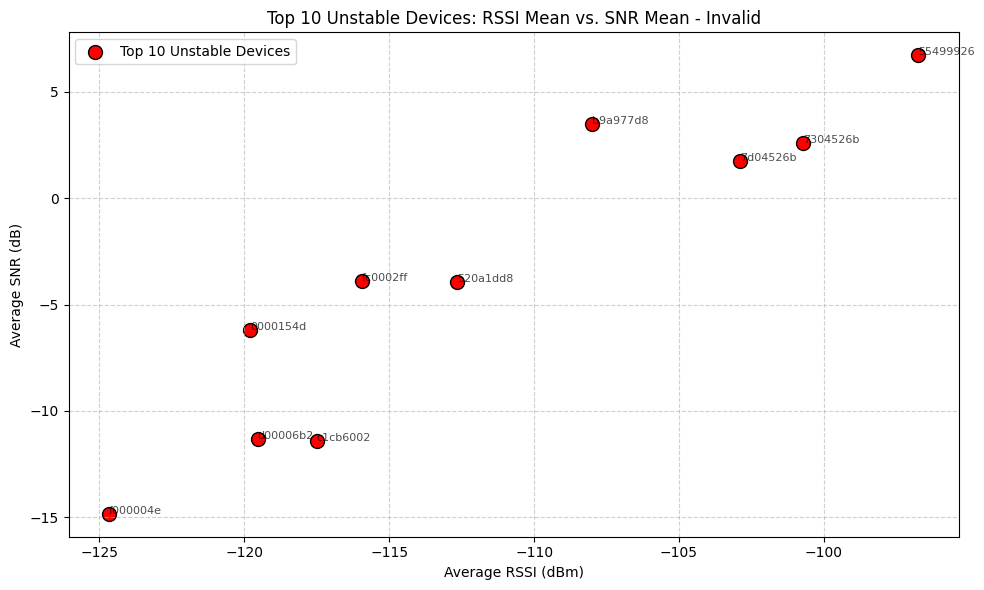

In [31]:
# Top 10 unstable devices (already calculated)
unstable_devices = most_unstable_devices.copy()

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(unstable_devices['rssi_mean'], unstable_devices['snr_mean'],
            color='red', edgecolor='black', s=100, label='Top 10 Unstable Devices')

# Label points with DevAddr
for i, row in unstable_devices.iterrows():
    plt.text(row['rssi_mean'], row['snr_mean'], row['DevAddr'], fontsize=8, alpha=0.7)

plt.title('Top 10 Unstable Devices: RSSI Mean vs. SNR Mean - Invalid')
plt.xlabel('Average RSSI (dBm)')
plt.ylabel('Average SNR (dB)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


🔹 Most devices have average RSSI around -125 to -100 dBm — typical for weak links in a LoRaWAN deployment.
🔹 The majority of SNR values are negative (as expected for these links), but:

A few devices (like 5499926, 9a977d8) have positive SNRs — indicating stronger link quality even with weaker RSSI.

Devices like 00004e have both weak RSSI and very low SNR — likely worst performance.

🔹 Spread of points:

Devices like 9a977d8, 5499926: outliers with surprisingly clean signals despite low RSSI.

Devices at the bottom left: consistently bad links (weak signal and noisy environment).

#### Spreading Factor (SF) Usage Patterns

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_21776/1071546244.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_frmpayload['sf_num'] = df_null_frmpayload['datr'].str.extract(r'SF(\d+)')[0].astype(float)


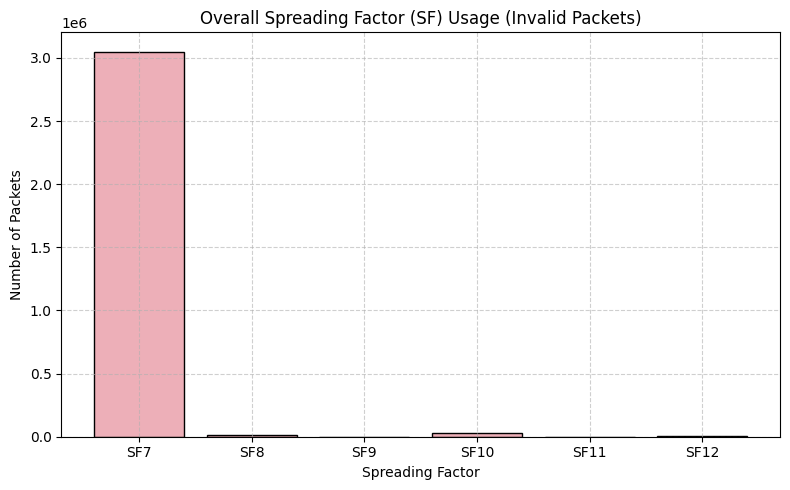

Spreading Factor usage counts:
sf_num
7.0     3050061
8.0       14746
9.0         106
10.0      26363
11.0         78
12.0       1912
Name: count, dtype: int64


In [32]:
import matplotlib.pyplot as plt

# Extract numeric SF (if not already done)
df_null_frmpayload['sf_num'] = df_null_frmpayload['datr'].str.extract(r'SF(\d+)')[0].astype(float)

# Count SF usage
sf_counts_invalid = df_null_frmpayload['sf_num'].value_counts().sort_index()

# Relabel for better plots
sf_labels = [f'SF{int(sf)}' for sf in sf_counts_invalid.index]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(sf_labels, sf_counts_invalid.values, color='#edafb8', edgecolor='black')
plt.title('Overall Spreading Factor (SF) Usage (Invalid Packets)')
plt.xlabel('Spreading Factor')
plt.ylabel('Number of Packets')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Spreading Factor usage counts:")
print(sf_counts_invalid)


🔹 SF7 dominates by a huge margin (over 3 million invalid packets!).
🔹 Other SFs (like SF8, SF9, SF10, SF11, SF12) have negligible invalid traffic.
🔹 The massive gap suggests that most invalid traffic occurs when using SF7.